<a href="https://colab.research.google.com/github/tedyadika/Azureml/blob/main/2_Data_eng_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Azure ML SDK modules

In [39]:
from azureml.core import Workspace, Datastore,Dataset,Experiment,Run

### Import python modules

In [61]:
%matplotlib inline
import datetime
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date,timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib
from pycaret.regression import *
#from lazypredict.Supervised import LazyRegressor

### Set up and data import 

In [41]:
ws = Workspace.get(name= 'dscglobalceedamlt',
                    subscription_id= '8b20e38c-72fb-4030-a702-128e713479ca',
                    resource_group= 'DSCGlobalCEEDTANLTst')

az_store= Datastore.get(ws,'datastore_sdk_blob1')
az_dataset= Dataset.get_by_name(ws,'country_sdk')
az_default_store = ws.get_default_datastore()

### set up experiment

In [42]:
experiment_run = Run.get_context()

In [43]:
dataset1 =az_dataset.to_pandas_dataframe()


Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


In [44]:
df = dataset1.copy()
df = df.drop(['DCRPL','ECOMM','RETAIL'], axis=1)
df['logarithm_base2'] = np.log10(df['SUM_QTY_TOTAL_PICKS'])

In [45]:
nulldf = df.isnull().sum()
for col in df.columns:
    experiment_run.log(col, nulldf[col])

Attempted to log scalar metric DATE:
0
Attempted to log scalar metric ORDTYP_map:
0
Attempted to log scalar metric DAY_YEAR:
0
Attempted to log scalar metric day_of_week:
0
Attempted to log scalar metric COUNTRY_NAME:
0
Attempted to log scalar metric NBR_ORDERS:
0
Attempted to log scalar metric SUM_QTY_TOTAL_PICKS:
0
Attempted to log scalar metric SUM_QTY_PIECE_PICKS:
0
Attempted to log scalar metric Month:
0
Attempted to log scalar metric Year:
0
Attempted to log scalar metric WEEK_YEAR:
0
Attempted to log scalar metric DATE_N:
0
Attempted to log scalar metric logarithm_base2:
0


### ploting

<Figure size 720x216 with 0 Axes>

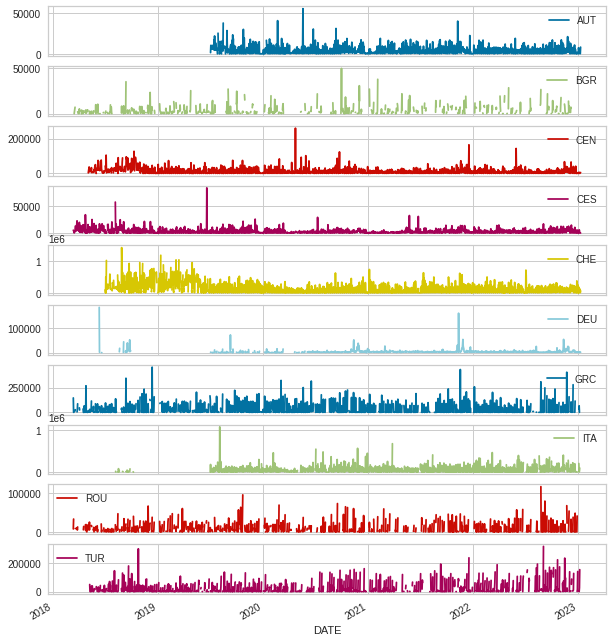

In [46]:
plt.figure(figsize=(10,3))   
pd.pivot_table(df.reset_index(),
               index='DATE', columns='COUNTRY_NAME', values='SUM_QTY_TOTAL_PICKS'
              ).plot(subplots=True,figsize=(10, 12))
           
plt.show()

### spliting our data by country 

In [47]:
# Initialize an empty list
df_list = []
# Split the dataframe into separate datasets based on the values in the 'country' column
for name, group in df.groupby('COUNTRY_NAME'):
  df_list.append(group)

# Print the list of dataframes
#print(df_list)


### Adding importang parameters to our data

In [114]:
def add_values(data):
    #data = df.copy()
    #data['logarithm_base2'] = np.log10(data['SUM_QTY_TOTAL_PICKS'])
    data.sort_values('DATE', inplace=True)
    data['DATE'] = pd.to_datetime(data['DATE'])
    data['MA18'] = data['logarithm_base2'].shift(35).rolling(2).mean()
    data['MA16'] = data['logarithm_base2'].shift(21).rolling(7).mean()
    data['Month'] = [i.month for i in data['DATE']]
    data['Year'] = [i.year for i in data['DATE']]
    data['WEEK_YEAR'] = data['DATE'].dt.isocalendar().week 
    data['day_of_week'] = data['DATE'].dt.dayofweek
    data['DAY_YEAR'] = data['DATE'].dt.dayofyear
    data['DATE_N'] = data['DATE'].apply(lambda x:x.toordinal())
    data["WEEK_YEAR"] = data["WEEK_YEAR"].astype('int64').astype('int64')
    #data = data.dropna()
    return(data)


for df in df_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)




### Adding Lags

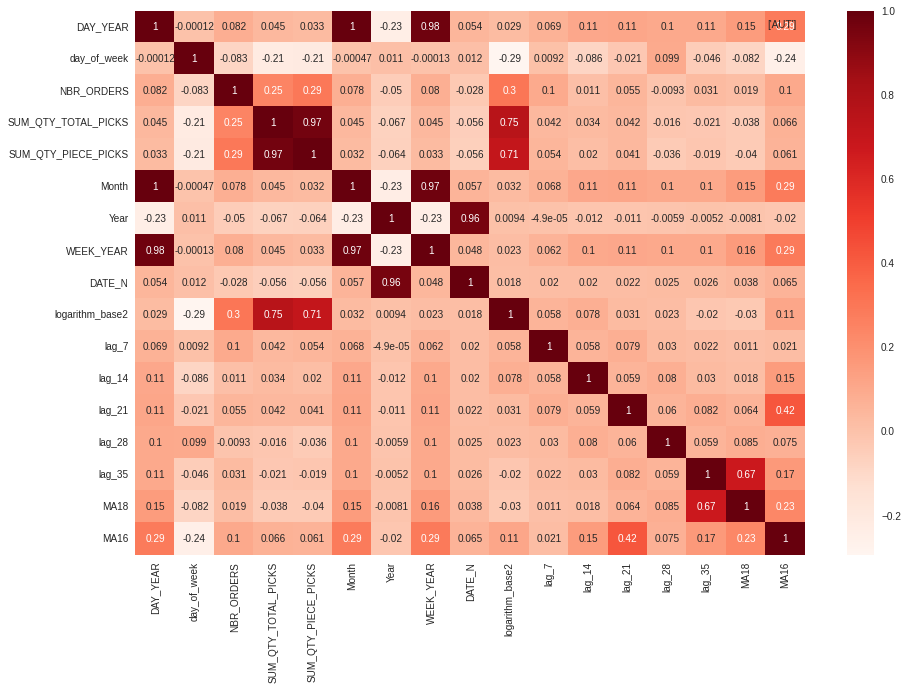

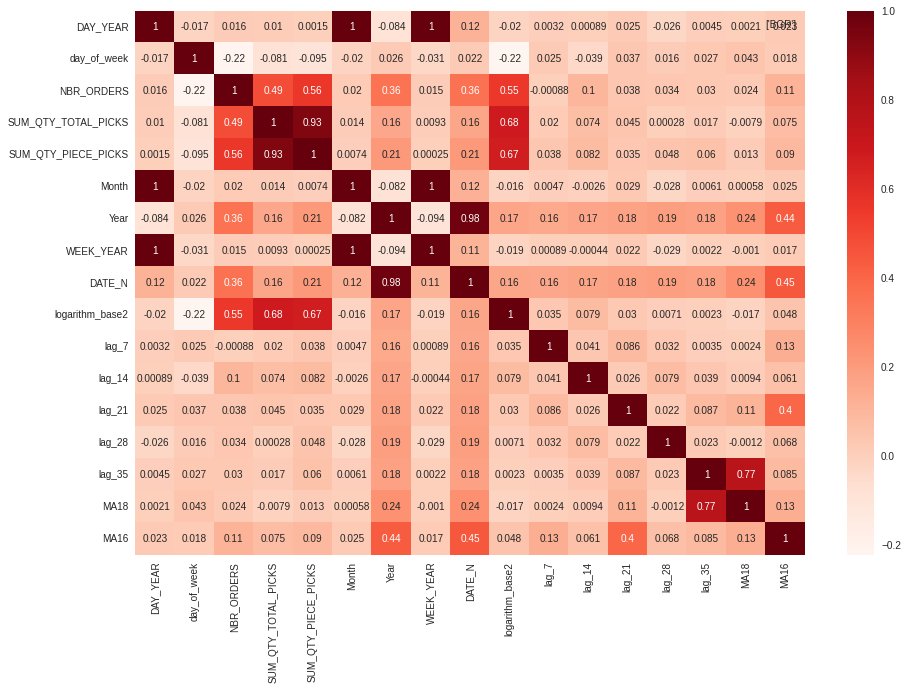

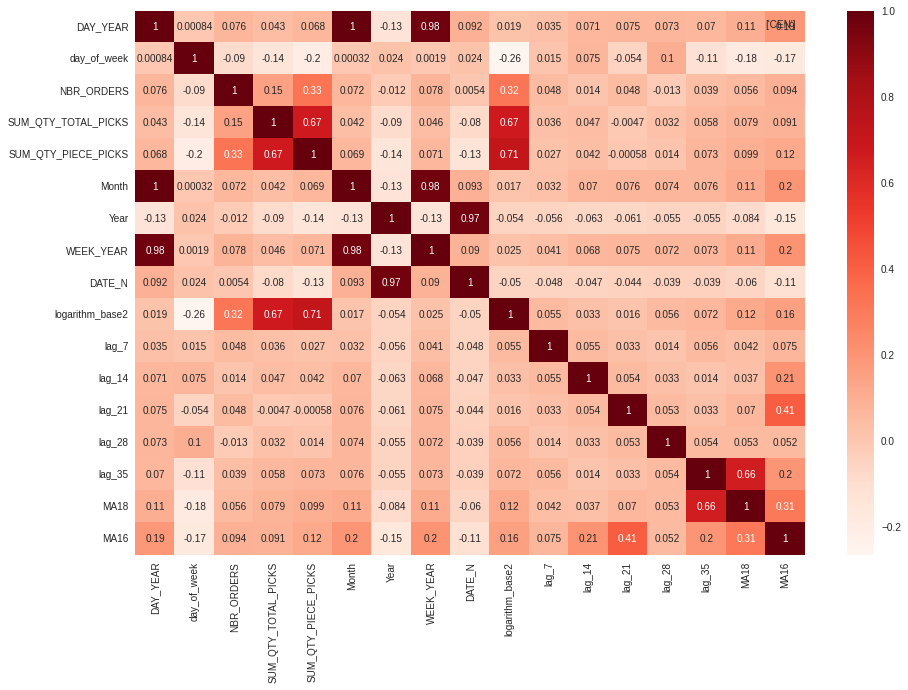

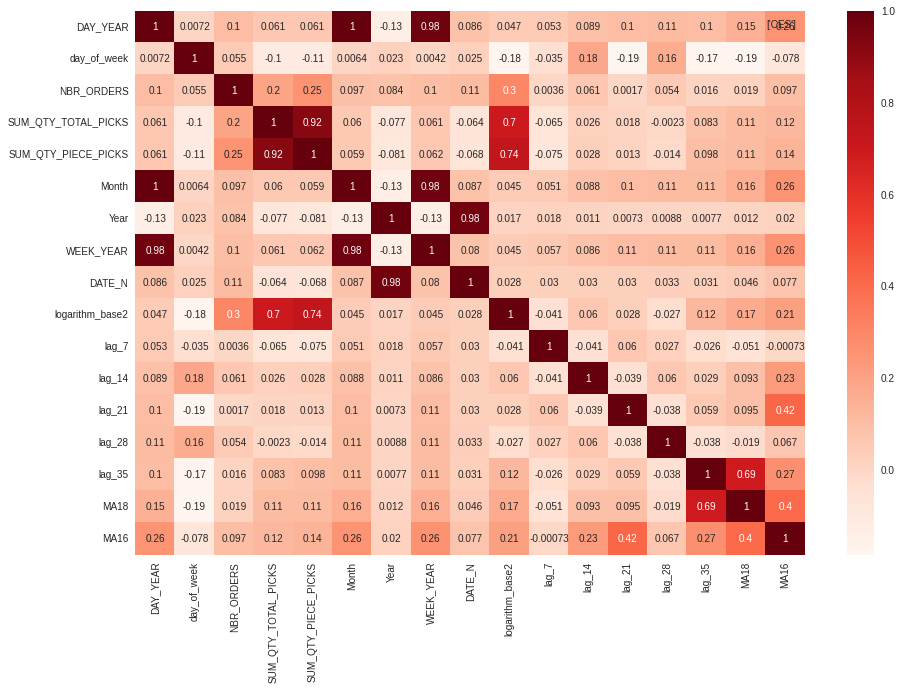

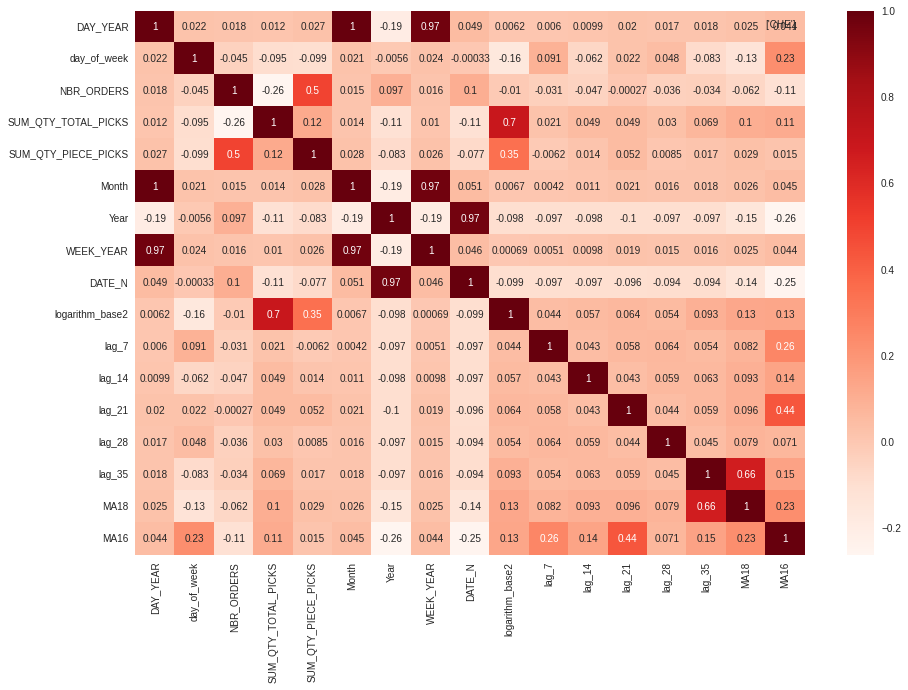

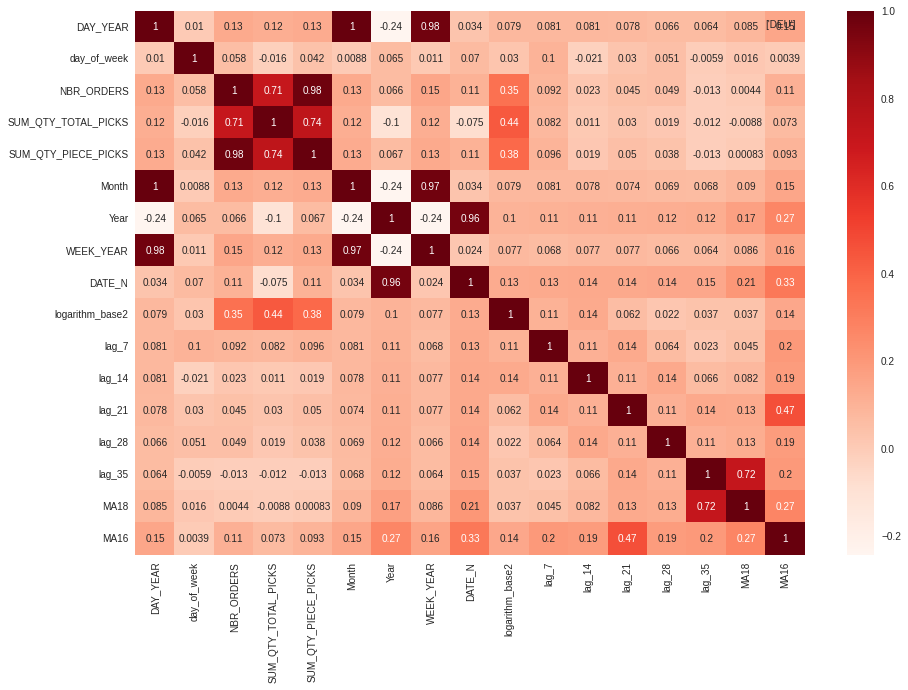

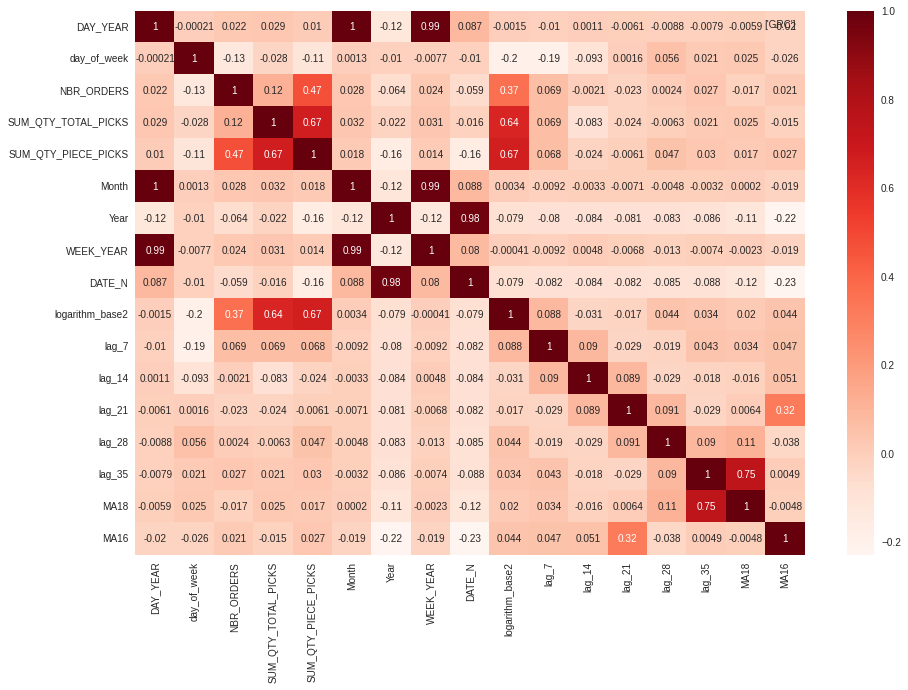

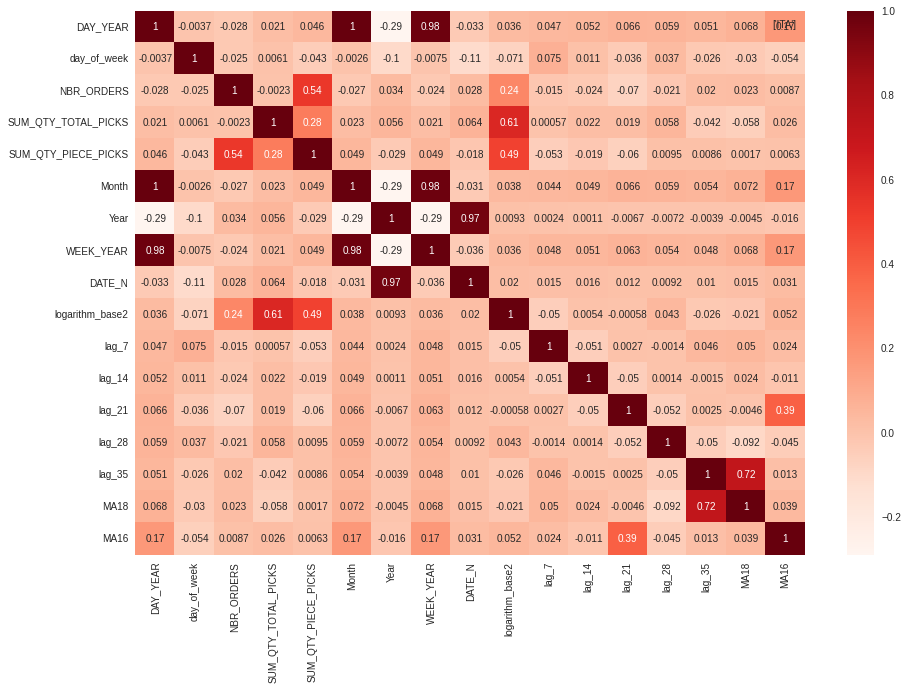

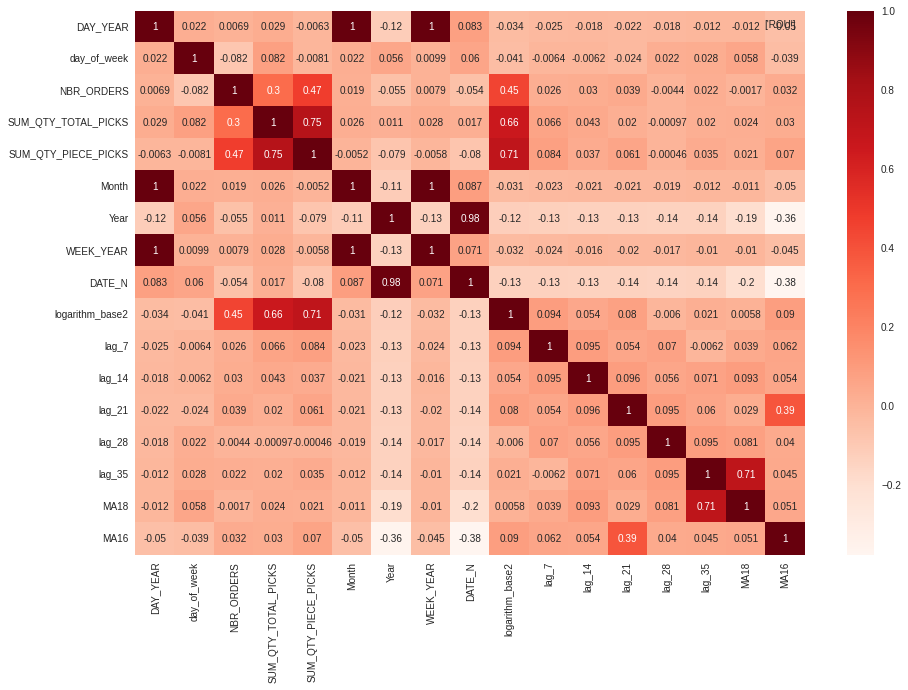

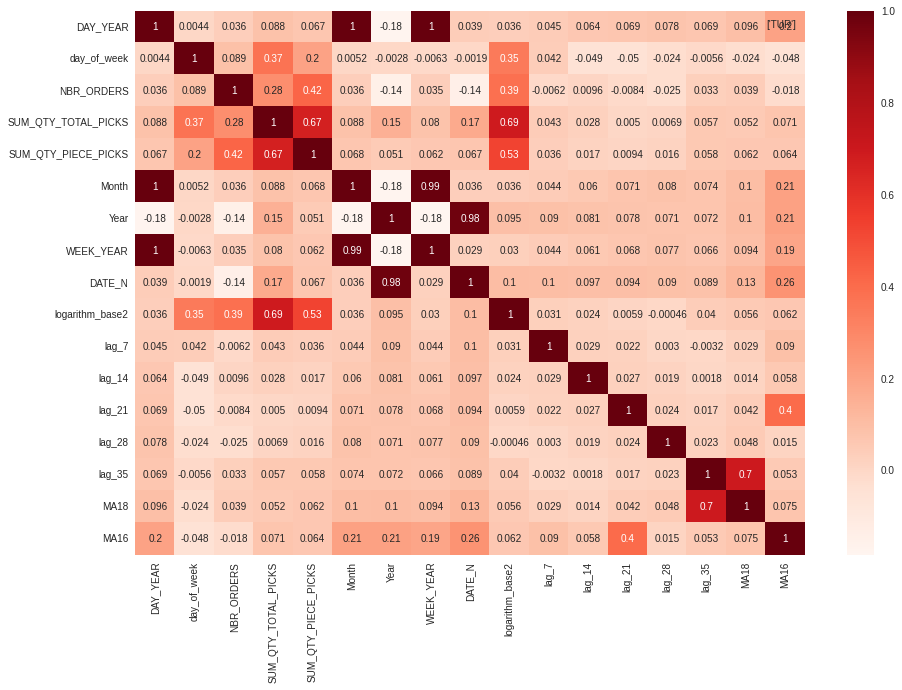

In [107]:
for df in df_list:
    label= df['COUNTRY_NAME'].unique()
    plt.figure(figsize=(15,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.legend(title = label)
    plt.show()

### AUSTRIA ML

In [133]:
Aut_data = df_list[0].copy()
Aut_data = Aut_data.drop(['ORDTYP_map','COUNTRY_NAME','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)
Aut_data.tail(2)

,DATE,DAY_YEAR,day_of_week,Month,Year,WEEK_YEAR,DATE_N,logarithm_base2,lag_7,lag_14,lag_21,lag_28,lag_35,MA18,MA16
19790,2023-01-09,9,0,1,2023,2,738529,4.205367,3.399154,1.505150,2.665581,4.025265,2.418301,2.137817,2.624436
19800,2023-01-09,9,0,1,2023,2,738529,2.599883,2.595496,4.133443,2.657056,2.385606,4.329215,3.373758,2.663214


### setting up our Algorithm

In [134]:
s = setup(Aut_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          #ignore_features = ['NBR_ORDERS','SUM_QTY_TOTAL_PICKS'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

### comparing and finding best model

In [135]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.5680,4.434000e-01,0.6658,1.354000e-01,0.1657,0.1912,0.2133
rf,Random Forest Regressor,0.5729,4.478000e-01,0.6690,1.276000e-01,0.1671,0.1951,1.0733
omp,Orthogonal Matching Pursuit,0.5765,4.494000e-01,0.6703,1.234000e-01,0.1671,0.1938,0.0233
gbr,Gradient Boosting Regressor,0.5804,4.755000e-01,0.6894,7.210000e-02,0.1708,0.1935,0.3533
et,Extra Trees Regressor,0.5933,4.897000e-01,0.6988,4.360000e-02,0.1750,0.2035,0.6233
lightgbm,Light Gradient Boosting Machine,0.5882,4.991000e-01,0.7058,2.670000e-02,0.1759,0.1995,0.3633
huber,Huber Regressor,0.6177,5.214000e-01,0.7219,-1.560000e-02,0.1806,0.2106,0.0267
dummy,Dummy Regressor,0.6164,5.232000e-01,0.7232,-1.930000e-02,0.1805,0.2091,0.0200
llar,Lasso Least Angle Regression,0.6164,5.232000e-01,0.7232,-1.930000e-02,0.1805,0.2091,0.0200
ridge,Ridge Regression,0.6127,5.302000e-01,0.7257,-3.800000e-02,0.1830,0.2103,0.0200


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123)
INFO:logs:compare_models() succesfully completed......................................


In [136]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

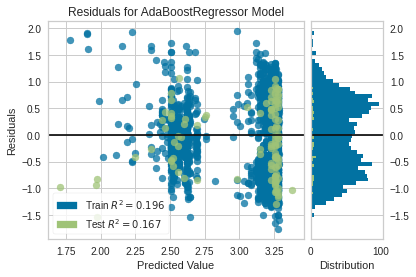

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [137]:
plot_model(best, plot = 'residuals')

### ploting our best features 

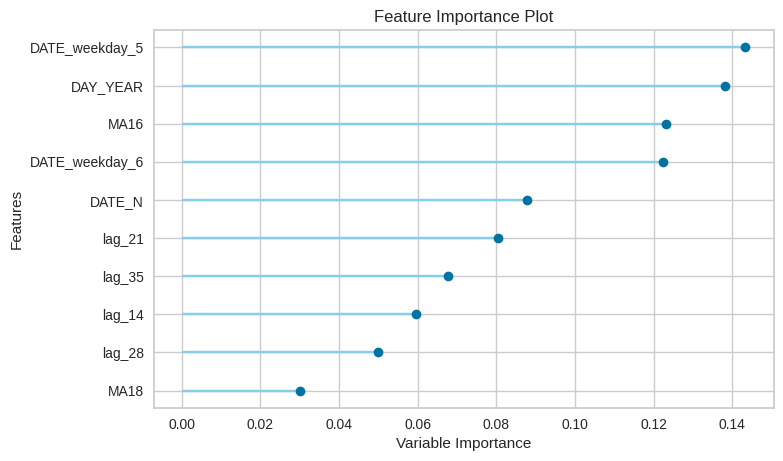

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [138]:
plot_model(best, plot = 'feature')

In [87]:
predict_model(best)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.56,0.4175,0.6461,0.1665,0.1587,0.1835


,DAY_YEAR,WEEK_YEAR,DATE_N,lag_7,lag_14,lag_21,lag_28,lag_35,MA18,MA16,...,DATE_month_6,DATE_month_8,DATE_weekday_1,DATE_weekday_2,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_0,logarithm_base2,Label
0,311.0,45.0,738466.0,4.528865,2.462398,2.478566,2.305351,2.472756,2.817362,3.124837,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.631444,3.262948
1,311.0,45.0,738466.0,2.440909,2.568202,4.276071,2.451787,3.593729,3.033243,3.385449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.433450,3.276523
2,312.0,45.0,738467.0,3.786893,3.972989,2.562293,2.496930,3.895257,3.744493,3.394787,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.340246,3.276523
3,312.0,45.0,738467.0,2.428135,3.730944,3.682867,4.324344,2.394452,3.144854,3.303147,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.502427,3.276523
4,313.0,45.0,738468.0,1.000000,2.517196,2.399674,3.938420,4.247556,3.321004,3.083326,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.859138,3.259218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,7.0,1.0,738527.0,3.868586,2.977724,2.158362,3.444045,3.672190,3.210577,2.908071,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.724276,2.506759
110,7.0,1.0,738527.0,3.788027,2.906335,2.158362,2.376577,2.511883,3.092037,2.876898,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.627366,2.365514
111,8.0,1.0,738528.0,2.731589,2.673942,3.407561,3.815113,1.857332,2.184608,2.818676,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.578639,2.554809
112,9.0,2.0,738529.0,3.399154,1.505150,2.665581,4.025265,2.418301,2.137817,2.624435,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.205367,3.259218


### **Save the model** 

In [88]:
save_model(best, 'AUT_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), model_name=AUT_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['NBR_ORDERS',
                                                       'SUM_QTY_TOTAL_PICKS'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='logarithm_base2',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None...
                ('scaling', 'passthr

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['NBR_ORDERS',
                                                        'SUM_QTY_TOTAL_PICKS'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='logarithm_base2',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None...
                 ('dummy', Dummify(target='logarithm_base2')),
                 ('fix_perfect', Remove_100(target='logarithm_base2')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fi

## loading saved model

In [32]:
loaded_model = load_model('AUT_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=AUT_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


## creating future dataset

In [156]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([Aut_data,future_data],ignore_index=True).fillna(0)

In [157]:
future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [167]:
Aut_future = future_list[0].tail(10)
Aut_future = Aut_future.drop('logarithm_base2',axis = 1)
predictions_aut = predict_model(best, data=Aut_future)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


In [168]:
predictions_aut['prediction'] = 10 ** predictions_aut['Label'] 
predictions_aut['country'] ='AUT' 
predictions_aut

,DATE,DAY_YEAR,day_of_week,Month,Year,WEEK_YEAR,DATE_N,lag_7,lag_14,lag_21,lag_28,lag_35,MA18,MA16,Label,prediction,country
2259,2023-01-07,7,5,1,2023,1,738527,3.788027,2.906335,2.158362,3.815113,2.511883,3.092037,2.671393,2.365514,232.014116,AUT
2260,2023-01-08,8,6,1,2023,1,738528,2.731589,2.673942,3.407561,2.376577,1.857332,2.184608,2.818676,2.554809,358.764254,AUT
2261,2023-01-09,9,0,1,2023,2,738529,3.399154,1.505150,2.665581,4.025265,2.418301,2.137817,2.624436,3.259218,1816.429125,AUT
2262,2023-01-09,9,0,1,2023,2,738529,2.595496,3.137671,2.657056,2.385606,4.329215,3.373758,2.663214,3.259218,1816.429125,AUT
2263,2023-01-10,10,1,1,2023,2,738530,2.737193,4.133443,2.804139,3.502154,2.418301,3.373758,2.563498,3.224903,1678.428868,AUT
2264,2023-01-11,11,2,1,2023,2,738531,3.119586,2.761176,3.505286,2.093422,2.348305,2.383303,2.765193,3.169034,1475.820816,AUT
2265,2023-01-12,12,3,1,2023,2,738532,1.724276,3.868586,2.977724,2.158362,3.444045,2.896175,2.882244,3.224903,1678.428868,AUT
2266,2023-01-13,13,4,1,2023,2,738533,2.627366,3.788027,2.906335,2.158362,3.815113,3.629579,2.989097,3.224903,1678.428868,AUT
2267,2023-01-14,14,5,1,2023,2,738534,2.578639,2.731589,2.673942,3.407561,2.376577,3.095845,2.884295,2.360252,229.219544,AUT
2268,2023-01-15,15,6,1,2023,2,738535,4.205367,3.399154,1.505150,2.665581,4.025265,3.200921,2.718519,2.605707,403.373504,AUT


### Register our Data output

In [170]:
try:
    Dataset.Tabular.register_pandas_dataframe(dataframe = predictions_aut,
                                               target = az_store,
                                               name = 'predictions_aut',
                                                description='predictions_aut')
except Exception as ex:
    print('Error register_pandas_dataframe: ', ex)

Message: rslex failed, falling back to clex.
Payload: {"pid": 4666, "source": "azureml.dataprep", "version": "4.8.3", "trace": "azureml|data|dataset_factory.py, line 655 in function register_pandas_dataframe.\nazureml|data|_loggerfactory.py, line 132 in function wrapper.\n<ipython-input-170-8c7b7ab23f2e>, line 2 in function <module>.", "subscription": "", "run_id": "", "resource_group": "", "workspace_name": "", "experiment_id": "", "location": "", "rslex_version": "2.15.1"}


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/72d6b203-81bd-43d8-8262-6bb664478261/
Successfully uploaded file to datastore.
Creating and registering a new dataset.


Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


Successfully created and registered a new dataset.


### complete the experiment

In [ ]:
experiment_run.complete()